In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch, os
torch.manual_seed(0) 
import warnings;warnings.filterwarnings("ignore")
from HINT.dataloader import csv_three_feature_2_dataloader, generate_admet_dataloader_lst
from HINT.molecule_encode import MPNN, ADMET 
from HINT.icdcode_encode import GRAM, build_icdcode2ancestor_dict
from HINT.protocol.model import ProtocolEmbedding
from HINT.model import HINTModel
device = torch.device("cuda:0")
if not os.path.exists("figure"):
	os.makedirs("figure")

In [4]:
ablations = [
    {"name": "disease_pred",
      "config": {
         "disease_embedding": True
     }
    },
    {"name": "molecule_pred",
      "config": {
         "molecule_embedding": True
     }
    },
    {"name": "protocol_pred",
      "config": {
         "protocol_embedding": True
     }
    },
    {"name": "interaction_pred",
      "config": {
         "interaction_embedding": True
     }
    },
    {"name": "disease_risk_pred",
      "config": {
         "disease_risk_embedding": True
     }
    },
    {"name": "augmented_interaction_pred",
      "config": {
         "augmented_interaction_embedding": True
     }
    },
    {"name": "pharmacokinetics_pred",
      "config": {
         "pk_embedding": True
     }
    },
     {"name": "trial_pred_nn",
      "config": {
         "trial_embedding": True
     }
    },
    {"name": "vanilla",
      "config": {
         "base_model": True
     }
    },
]

In [24]:
ablations = [
      {"name": "disease_pred",
      "config": {
         "disease_embedding": True
     }
    },
]

In [25]:
phase_name = 'phase_III'
model_name = 'icd_protocol'
datafolder = "data"
train_file = os.path.join(datafolder, phase_name + '_train.csv')
valid_file = os.path.join(datafolder, phase_name + '_valid.csv')
test_file = os.path.join(datafolder, phase_name + '_test.csv')

In [26]:
mpnn_model = MPNN(mpnn_hidden_size = 50, mpnn_depth=3, device = device)
admet_model_path = "save_model/admet_model.ckpt"
if not os.path.exists(admet_model_path):
	admet_dataloader_lst = generate_admet_dataloader_lst(batch_size=32)
	admet_trainloader_lst = [i[0] for i in admet_dataloader_lst]
	admet_testloader_lst = [i[1] for i in admet_dataloader_lst]
	admet_model = ADMET(molecule_encoder = mpnn_model, 
						highway_num=2, 
						device = device, 
						epoch=3, 
						lr=5e-4, 
						weight_decay=0, 
						save_name = 'admet_')
	admet_model.train(admet_trainloader_lst, admet_testloader_lst)
	torch.save(admet_model, admet_model_path)
else:
	admet_model = torch.load(admet_model_path)
	admet_model = admet_model.to(device)
	admet_model.set_device(device)

In [27]:
train_loader = csv_three_feature_2_dataloader(train_file, shuffle=True, batch_size=32) 
valid_loader = csv_three_feature_2_dataloader(valid_file, shuffle=False, batch_size=32) 
test_loader = csv_three_feature_2_dataloader(test_file, shuffle=False, batch_size=32) 

In [28]:
icdcode2ancestor_dict = build_icdcode2ancestor_dict()
gram_model = GRAM(embedding_dim = 50, icdcode2ancestor = icdcode2ancestor_dict, device = device)
protocol_model = ProtocolEmbedding(output_dim = 50, highway_num=3, device = device)

Running ablation disease_pred...
PR-AUC   mean: 0.7714 std: 0.0118
F1       mean: 0.8320 std: 0.0081
ROC-AUC  mean: 0.6719 std: 0.0158
Accuracy mean: 0.7740 std: 0.0120


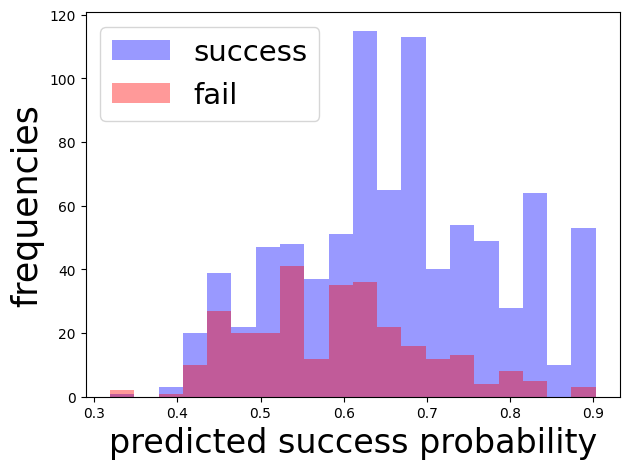

In [29]:
for ablation in ablations:
    hint_model_path = "save_model/" + ablation["name"] + ".ckpt"
    print(f"Running ablation {ablation['name']}...")
    
    if not os.path.exists(hint_model_path):
        model = HINTModel(molecule_encoder = mpnn_model, 
                 disease_encoder = gram_model, 
                 protocol_encoder = protocol_model,
                 device = device, 
                 global_embed_size = 50, 
                 highway_num_layer = 2,
                 prefix_name = model_name, 
                 gnn_hidden_size = 50,  
                 epoch = 3,
                 lr = 1e-3, 
                 weight_decay = 0,
                 ablations=ablation
                )
        model.init_pretrain(admet_model)
        model.learn(train_loader, valid_loader, test_loader)
        model.bootstrap_test(test_loader, sample_num = 50)
        torch.save(model, hint_model_path)
    else:
        model = torch.load(hint_model_path)
        nctid_all, predict_all = model.bootstrap_test(test_loader)

In [30]:
from collections import Counter
predictions = [0 if pred < 0.5 else 1 for pred in predict_all]
prediction_counts = Counter(predictions)

print(prediction_counts)


Counter({1: 996, 0: 150})
